In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "../data/carotenoid_training_data.csv"
df = pd.read_csv(file_path)
INPUT_VARS = df.columns[:-1]
RESPONSE_VARS = df.columns[-1]

print(f'Input variables: {INPUT_VARS.values}'
      f'\nResponse variable: {RESPONSE_VARS}')
print(f'Shape of the dataframe: {df.shape}')

# Calculate bounds of proteins
def get_bounds(df: pd.DataFrame, input_vars: list, epsilon: float=0.10):
    bounds = pd.DataFrame(columns=input_vars)
    X = df[input_vars]
    for col in input_vars:
        MAX = X[col].max()
        MIN = X[col].min()
        DELTA = MAX - MIN
        lb = MIN - epsilon * DELTA
        ub = MAX + epsilon * DELTA
        if lb < 0:
            lb = 0
        bounds.loc["min", col] = lb
        bounds.loc["max", col] = ub
    return bounds

bounds = get_bounds(df, INPUT_VARS)
display(bounds)

Input variables: ['ERG8' 'ERG10' 'ERG12' 'ERG13' 'ERG19' 'ERG20' 'IDI1' 'tHMG1']
Response variable: prod
Shape of the dataframe: (168, 9)


,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1
min,0,0,0,0,0,0,0,0
max,21.723829,21.762191,25.871048,23.314336,21.509215,22.215345,6.946964,21.686637


In [32]:
df.sort_values(by='prod', ascending=False, inplace=True)

df_test = df[:10].copy()
df = df[10:].copy()

In [34]:
# import all above models
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from tqdm import tqdm
import matplotlib.pyplot as plt

regressors = {
    'LR': LinearRegression(),
    'RF': RandomForestRegressor(),
    'SVR': SVR(),
    'MLP': MLPRegressor(),
    'XGB': XGBRegressor(),
    'kNN': KNeighborsRegressor(),
    'GB': GradientBoostingRegressor(),
}

# Define hyperparameter grid for each model
param_grid = {
    'LR': {'fit_intercept': [True, False]},
    'RF': {'n_estimators': [3, 5, 10, 20, 50], 'max_depth': [None, 2, 3, 5, 10, 20]},
    'SVR': {'kernel': ['linear', 'rbf'], 'C': [0.01, 0.1, 1, 5, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]},
    'MLP': {'hidden_layer_sizes': [(25,), (10,)], 'activation': ['relu']},
    'XGB': {'n_estimators': [5, 10, 20, 50], 'max_depth': [None, 2, 3, 5, 10, 20]},
    'kNN': {'n_neighbors': [1, 2, 3, 5, 10], 'weights': ['uniform', 'distance']},
    'GB': {'n_estimators': [10, 20, 50], 'max_depth': [None, 2, 3, 5, 10]},
}

def model_selection():
    '''
        Define a function to perform the nested Cross Validation
    '''
    def nestedCV(model, p_grid, X, y):
        NUM_TRIALS = 3

        # Arrays to store scores
        nested_scores = []

        # Loop for each trial
        for i in tqdm(range(NUM_TRIALS)):
            
            inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
            outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

            # Nested CV with parameter optimization
            clf = GridSearchCV(estimator=model, scoring='neg_mean_absolute_error', param_grid=p_grid, 
                                    cv=inner_cv)
            
            nested_score = cross_val_score(clf, X=X, y=y, 
                                        scoring='neg_mean_absolute_error', cv=outer_cv)
            
            nested_scores.append(list(nested_score))
        return clf, nested_scores

    nested_LR, nested_LR_scores = nestedCV(regressors['LR'], param_grid['LR'], df[INPUT_VARS], df[RESPONSE_VARS].values.ravel())
    nested_RF, nested_RF_scores = nestedCV(regressors['RF'], param_grid['RF'], df[INPUT_VARS], df[RESPONSE_VARS].values.ravel())
    nested_SVR, nested_SVR_scores = nestedCV(regressors['SVR'], param_grid['SVR'], df[INPUT_VARS], df[RESPONSE_VARS].values.ravel())
    nested_MLP, nested_MLP_scores = nestedCV(regressors['MLP'], param_grid['MLP'], df[INPUT_VARS], df[RESPONSE_VARS].values.ravel())
    nested_XGB, nested_XGB_scores = nestedCV(regressors['XGB'], param_grid['XGB'], df[INPUT_VARS], df[RESPONSE_VARS].values.ravel())
    nested_kNN, nested_kNN_scores = nestedCV(regressors['kNN'], param_grid['kNN'], df[INPUT_VARS], df[RESPONSE_VARS].values.ravel())
    nested_GB, nested_GB_scores = nestedCV(regressors['GB'], param_grid['GB'], df[INPUT_VARS], df[RESPONSE_VARS].values.ravel())

    nested_scores_LR = [-item for sublist in nested_LR_scores for item in sublist]
    nested_scores_RF = [-item for sublist in nested_RF_scores for item in sublist]
    nested_scores_SVR = [-item for sublist in nested_SVR_scores for item in sublist]
    nested_scores_MLP = [-item for sublist in nested_MLP_scores for item in sublist]
    nested_scores_XGB = [-item for sublist in nested_XGB_scores for item in sublist]
    nested_scores_kNN = [-item for sublist in nested_kNN_scores for item in sublist]
    nested_scores_GB = [-item for sublist in nested_GB_scores for item in sublist]
        
    # Create a box plot for the nested scores
    def boxplot(save=True):
        plt.figure(figsize=(12, 8))
        positions = [i for i in range(1, len(regressors))]
        plt.boxplot([nested_scores_LR, nested_scores_RF, nested_scores_SVR, nested_scores_MLP, nested_scores_XGB, nested_scores_kNN, nested_scores_GB], labels=['LR', 'RF', 'SVR', 'MLP', 'XGB', 'kNN', 'GB'])
        plt.ylabel('MAE')
        plt.show()

        print(f'Mean MAE for LR: {sum(nested_scores_LR)/len(nested_scores_LR)}')
        print(f'Mean MAE for RF: {sum(nested_scores_RF)/len(nested_scores_RF)}')
        print(f'Mean MAE for SVR: {sum(nested_scores_SVR)/len(nested_scores_SVR)}')
        print(f'Mean MAE for MLP: {sum(nested_scores_MLP)/len(nested_scores_MLP)}')
        print(f'Mean MAE for XGB: {sum(nested_scores_XGB)/len(nested_scores_XGB)}')
        print(f'Mean MAE for kNN: {sum(nested_scores_kNN)/len(nested_scores_kNN)}')
        print(f'Mean MAE for GB: {sum(nested_scores_GB)/len(nested_scores_GB)}')

    boxplot()

In [35]:
def train_svr(X, y):
    svr = SVR()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid['SVR'], 
                            scoring='neg_mean_absolute_error', cv=5)
    grid_search.fit(X, y)
    print("Best Score:", -grid_search.best_score_)
    return grid_search

grid_search = train_svr(df[INPUT_VARS], df[RESPONSE_VARS].values.ravel())
print(grid_search.best_params_)

Best Score: 1.5276622344556086
{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


#### Explainable AI 

ExactExplainer explainer: 159it [00:25,  3.85it/s]                                                                      


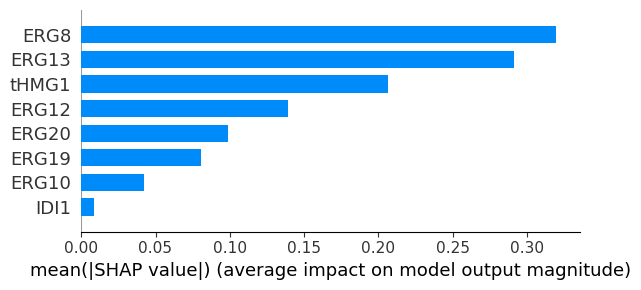

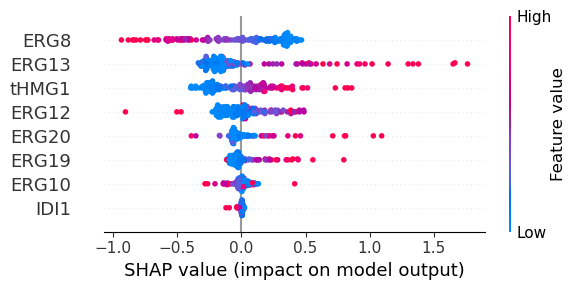

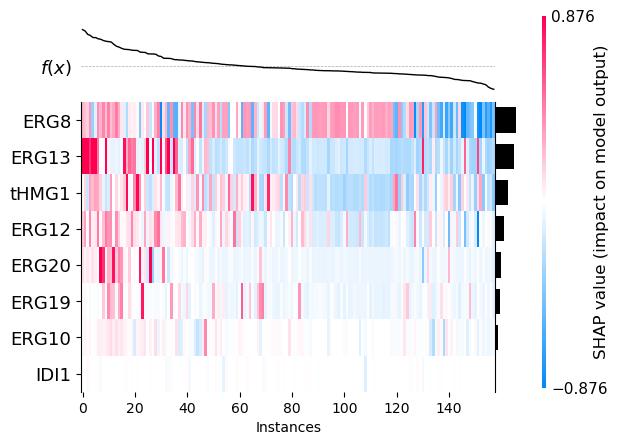

In [36]:
import shap

def pdplot(X: np.array, col: str, model: object, ice: bool=False):
    shap.plots.partial_dependence(col, model.predict, X, ice=ice, model_expected_value=True, feature_expected_value=True, show=True)
    
def shap_scatter(feature: str, color=None):
    if color:
        shap.plots.scatter(shap_values[:, feature], color=shap_values[:, color])
    else:
        shap.plots.scatter(shap_values[:, feature])

explainer = shap.Explainer(grid_search.best_estimator_.predict, df[INPUT_VARS])
shap_values = explainer(df[INPUT_VARS])
shap.summary_plot(shap_values, df[INPUT_VARS], plot_type="bar", plot_size=(6, 3))
shap.summary_plot(shap_values, df[INPUT_VARS], plot_type="dot", plot_size=(6, 3))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1), plot_width=6)

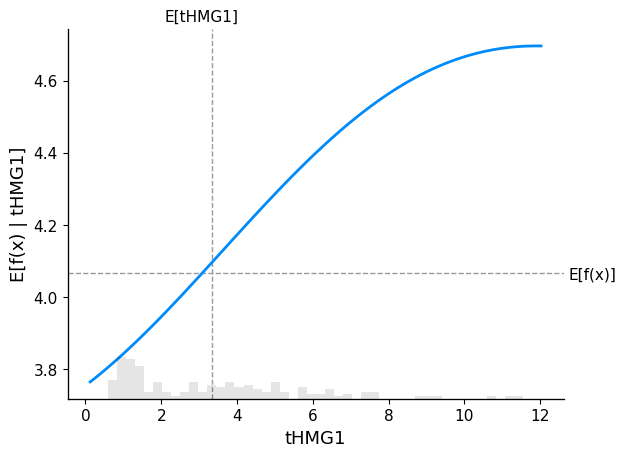

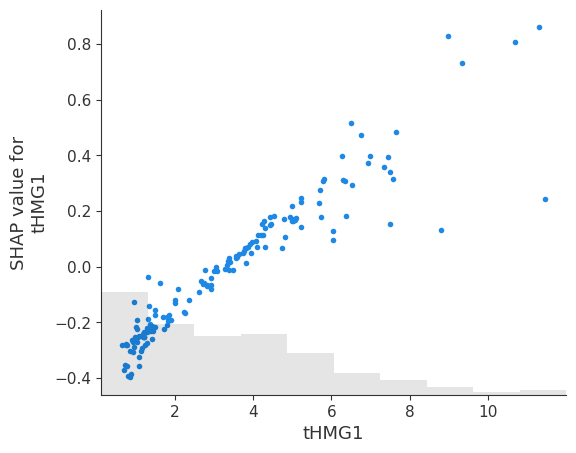

In [42]:
feature = 'tHMG1'
pdplot(df[INPUT_VARS], feature, grid_search.best_estimator_, ice=False)
shap_scatter(feature)

#### Sampling

In [20]:
df.columns

Index(['ERG8', 'ERG10', 'ERG12', 'ERG13', 'ERG19', 'ERG20', 'IDI1', 'tHMG1',
       'prod'],
      dtype='object')

In [23]:
sampling_bounds = pd.DataFrame(columns=bounds.columns, index=bounds.index)

sampling_bounds['ERG8'].loc['min'] = 13
sampling_bounds['ERG8'].loc['max'] = bounds['ERG8'].loc['max']

sampling_bounds['ERG10'].loc['min'] = 1.75
sampling_bounds['ERG10'].loc['max'] = bounds['ERG10'].loc['max']

sampling_bounds['ERG12'].loc['min'] = bounds['ERG12'].loc['min']
sampling_bounds['ERG12'].loc['max'] = 1.0

sampling_bounds['ERG13'].loc['min'] = bounds['ERG13'].loc['min']
sampling_bounds['ERG13'].loc['max'] = 1.0

sampling_bounds['ERG19'].loc['min'] = bounds['ERG19'].loc['min']
sampling_bounds['ERG19'].loc['max'] = 0.7

sampling_bounds['ERG20'].loc['min'] = 3.0
sampling_bounds['ERG20'].loc['max'] = bounds['ERG20'].loc['max']

sampling_bounds['IDI1'].loc['min'] = bounds['IDI1'].loc['min']
sampling_bounds['IDI1'].loc['max'] = 0.6

sampling_bounds['tHMG1'].loc['min'] = 1
sampling_bounds['tHMG1'].loc['max'] = bounds['tHMG1'].loc['max']


# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(100)
LB = sampling_bounds.T['min'].values.tolist()
UB = sampling_bounds.T['max'].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["pred"] = grid_search.best_estimator_.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df.head(10)

,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,pred
61,13.945173,17.446857,0.230322,0.132669,0.691960,6.033143,0.391655,19.881327,9.192253
33,16.411401,5.875529,0.826904,0.905453,0.256009,17.931110,0.233287,21.592280,8.788979
39,13.016238,3.944839,0.098175,0.706711,0.585533,7.206029,0.164332,20.960552,8.779107
11,14.680214,16.746004,0.283631,0.059522,0.105882,13.087323,0.221869,19.342387,8.457244
58,13.398013,12.681014,0.847121,0.546068,0.146098,5.294162,0.026816,17.784516,8.210003
94,18.378162,16.490861,0.909461,0.501233,0.386059,4.892145,0.318590,19.779307,8.002316
72,16.396260,9.520877,0.446720,0.412319,0.301530,18.751848,0.457452,19.589768,7.898776
7,15.040913,21.416705,0.999090,0.970087,0.370275,20.864722,0.529207,18.406116,7.770793
91,19.122430,10.034575,0.027157,0.931124,0.149615,20.598777,0.089055,21.263774,7.614571
47,13.596003,9.205854,0.290142,0.448425,0.615503,7.639797,0.389290,17.330703,7.486893


In [41]:
df_test.describe()

,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,prod
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,4.281015,3.191222,3.624392,4.687267,3.941723,3.783871,1.683428,10.825999,9.205303
std,3.476336,3.096391,3.014070,3.922209,4.849041,4.684783,1.674255,5.641701,0.787231
min,0.322517,0.999343,0.214028,1.082033,0.765969,0.910173,0.470616,2.945630,8.425106
25%,1.307890,1.124405,1.233578,1.405744,1.453250,1.096924,1.018507,7.456209,8.585441
50%,3.746877,1.459510,2.696487,3.027569,2.033794,1.481611,1.322664,9.992939,8.974261
75%,6.835973,4.082329,5.194167,7.280352,2.495769,3.757217,1.492914,13.475064,9.514421
max,10.524327,10.358183,9.138525,11.495731,15.194294,14.412210,6.340866,19.775550,10.563800


In [40]:
df.describe()

,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,prod
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,4.645458,2.954134,3.964976,5.050598,1.821481,2.771916,1.322632,3.334386,4.246245
std,3.922416,2.921052,4.291261,4.946791,2.484811,3.916246,0.742402,2.381082,1.628144
min,0.556408,0.796111,0.359754,0.649668,0.402684,0.547001,0.279885,0.664684,1.144454
25%,1.318791,1.114056,1.254421,1.501848,0.832070,0.981141,0.928769,1.288829,3.159763
50%,3.688132,1.640936,2.034151,2.710749,1.032074,1.176239,1.132268,2.934728,3.888343
75%,6.684575,3.636175,5.255934,6.686734,1.392295,2.079467,1.417696,4.772393,5.022505
max,19.778255,19.856184,23.538591,21.253911,19.590439,20.245496,5.372577,11.457117,8.422814


In [ ]:
# import all 4 sdv models under the single table scenario
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_A.drop('Limonene', axis=1))

model_Gaussian = GaussianCopulaSynthesizer(metadata)
model_Gaussian.fit(df_A.drop('Limonene', axis=1))
synthetic_data = model_Gaussian.sample(1000)
synthetic_data['Limonene'] = grid_search.best_estimator_.predict(synthetic_data)
synthetic_data.sort_values(by='Limonene', ascending=False, inplace=True)
synthetic_data